In [1]:
import ufl
from ufl import  TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate

import dolfinx
from dolfinx import mesh, fem, io,nls,log
from dolfinx.fem import FunctionSpace, locate_dofs_geometrical, form
from dolfinx.fem.petsc import LinearProblem, NonlinearProblem

from mpi4py import MPI
import petsc4py.PETSc 
import numpy as np
import matplotlib.pyplot as plt


# Operators:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.inner)
from ufl import dx, ds, grad, exp, div

npor = Infix(np.logical_or)
npand = Infix(np.logical_and)


# Classes:
def Function(space, func=None):
    """function function on new space. 
    Default create just Function on space

    Args:
        space (FunctionSpace): New space
        function (): Any function

    Returns:
        fem.Function: Function
    """
    if func == None: return fem.Function(space)
    if hasattr(func, 'ufl_domain'):
        func2 = func
    else:
        func2 = fem.Function(space)
        func2.interpolate(func)

    expr = fem.Expression(func2, space.element.interpolation_points())
    func2 = fem.Function(space)
    func2.interpolate(expr)
    return func2


def Constant(space, const):
    """Constant on space

    Args:
        space (FunctionSpace): Space
        const (auny number): Any number

    Returns:
        Constant: Constant on
    """
    return fem.Constant(space, petsc4py.PETSc.ScalarType(const))


def create_facet_markers(bound_markers, domain):
    """Mark facets under conditious

    Args:
        bound_markers (tuple): List of mark and function
        domain (Domain): Domain
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


def DirichletBC(space, func, combined_marker):
    
    
    """Create Dirichlet condition

    Args:
        func (Function/Constant): Function
        combined_marker (List): 
        \nFunction - boundary marker function 
        \nAll - all boundary
        \n[Marked_facets, marker] - marker of boundary from Marked_facets
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def get_exterior_facets():
        exterior_facets = mesh.exterior_facet_indices(domain.topology)
        return exterior_facets

    def all_dirichlet(dofs, func):
        if hasattr(func, 'function_space'):
            bc = fem.dirichletbc(dofs=dofs, value=func)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=func)
        return bc

    domain = space.mesh

    if combined_marker == 'All':
        facets = get_exterior_facets()
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == list:
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )
    else:
        dofs = fem.locate_dofs_geometrical(space, marker=marker)

    bc = all_dirichlet(dofs, func)

    return bc


# Post processing:
def get_L_errors(uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain,
        ('CG', uS.function_space.element.space_dimension),
        )
    uEx = Function(V_err, uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph

    Args:
        fig (figure): Figure
        lists (u , ax, title): List of arguments
        method (bool): Graph method: True= tripcolor, False= tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return

In [2]:
N = 10
domain = mesh.create_unit_square(
    MPI.COMM_WORLD,
    N,
    N,
    # cell_type=mesh.CellType.quadrilateral,
    )
V = FunctionSpace(domain, ('CG', 1))
x, y = SpatialCoordinate(V)
create_connectivity(domain=domain)

euEx =  1 + x + 2*y
euD = euEx
q = lambda u: 1+ u**2

f = -div(q(euEx)*grad(euD))

In [3]:
u, v = Function(V), TestFunction(V)
uEx = Function(V, euEx)
uD = Function(V, euD)

bcs = [
    DirichletBC(space=V,func=uD,combined_marker='All'),
    ]

F = q(u) * (grad(u)|dot|grad(v))*dx - f*v*dx

In [4]:
problem = NonlinearProblem(
    F=F,
    u=u,
    bcs=bcs
)

solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD,problem=problem)
solver.convergence_criterion = 'incremental'
solver.rtol= 1E-6
solver.report = True
ksp = solver.krylov_solver
opts = petsc4py.PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

# log.set_log_level(log.LogLevel.INFO)
n_itterations , converged = solver.solve(u)
assert (converged)

uS= u

In [8]:
opts.getAll()

{'nls_solve_ksp_type': 'cg',
 'nls_solve_pc_factor_mat_solver_type': 'mumps',
 'nls_solve_pc_type': 'gamg'}

In [5]:
L1_norm,L2_norm = get_L_errors(uEx=uEx,uS=uS)
print(f'L1 = {L1_norm:.2e}\nL2={L2_norm:.2e}')

L1 = 1.65e-15
L2=2.93e-15


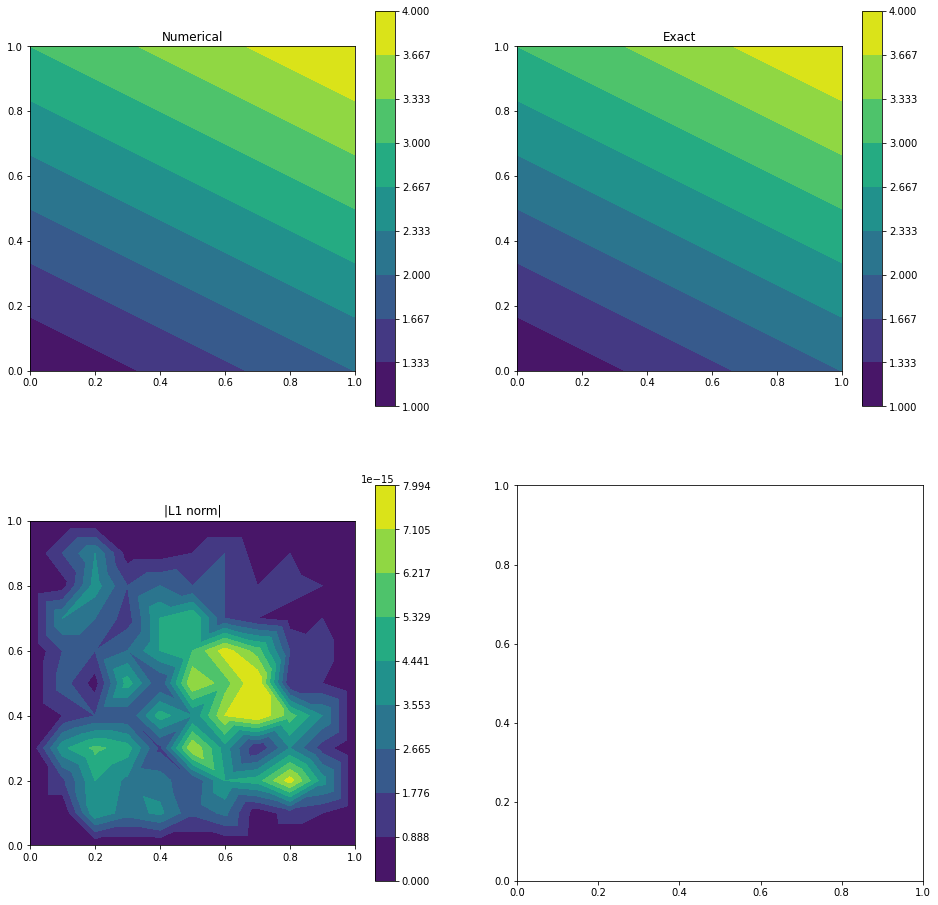

In [6]:
fig, ((ax, ax_donm),(ax_dif,ax2)) = plt.subplots(2, 2)
fig.set_size_inches(16, 16)

lis = [
    [uS, ax, 'Numerical'],
    [uEx, ax_donm, 'Exact'],
    [Function(V,abs(uS- uEx)), ax_dif, '|L1 norm|'],
    ]

graph2D(
    fig=fig,
    lists=lis,
    natural_show=False,
    # points_on=True
    )